In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# 초로 바꿔주는 함수
def convert_to_sec(args):
    largs = list(args)
    return 3600 * largs[0] + 60 * largs[1] + largs[2]

In [8]:
# 데이터 전처리
def preprocess(date : str):
    # 읽기
    data = pd.read_csv("data\\5511_" + date + ".csv")
    
    # column 따두기 및 맨 윗줄 지우기
    columns = data.iloc[0, 2:11]
    columns[0] = "환산시각(초)"
    columns[-1] = "버스 환산시각(초)"
    data = data.drop(0, axis=0)

    # 시각 빈곳 채우기
    for i in range(3):
        for j in range(data.shape[0]):
            if data.iloc[j, i] is np.NaN:
                data.iloc[j, i] = data.iloc[j - 1, i]

    # 아랫쪽 빈곳 지우기
    key = [row + 1 for row in range(data.shape[0]) if all(data.iloc[row, 0:8].isnull())]
    data = data.drop(key, axis=0)
    
    # 시간 변환하기 및 column 세팅하기
    for i in range(data.shape[0]):
        data.iloc[i, 2] = convert_to_sec(map(int, data.iloc[i, 0:3]))
        if all(data.iloc[i, 10:13].notna()):
            data.iloc[i, 10] = convert_to_sec(map(int, data.iloc[i, 10:13]))
    data = data.iloc[:, 2:11]
    data.columns = columns
    data = data.drop(["버스 오기 전", "버스 번호"], axis=1)

    return data

In [9]:
def draw(data):
    # 버스 소요 시간
    bus_time = []
    for i in range(data.shape[0]):
        if data.iloc[i, -1] is not np.nan:
            bus_time.append(data.iloc[i, -1] - data.iloc[i, 0])
    # bus_time = list(filter(lambda x: x < 1100, bus_time)) # outlier 제거
    
    plt.figure()
    sns.kdeplot(bus_time)
    plt.savefig("graphs\버스 소요 시간_공입5511.png")

    # 버스(유입, 이탈 포함) 도착 주기 및 인원
    buses = ["온 사람", "5511", "5516", "차고지", "이탈"]
    for k in range(len(buses)):
        arrive_period = []
        delta_people = []
        tmp = 0
        for i in range(data.shape[0]):
            if data.iloc[i, :].notna()[k + 1]:
                delta_people.append(int(data.iloc[i, k + 1]))
                if tmp > data.iloc[i, 0]:
                    tmp = 0
                    
                if tmp == 0:
                    tmp = data.iloc[i, 0]
                else:
                    arrive_period.append(data.iloc[i, 0] - tmp)
                    tmp = data.iloc[i, 0]    

        plt.figure()
        sns.kdeplot(arrive_period)
        plt.savefig("graphs\도착 주기_공입" + buses[k] + ".png")

        plt.figure()
        sns.kdeplot(delta_people)
        plt.savefig("graphs\인원수 분포_공입" + buses[k] + ".png")


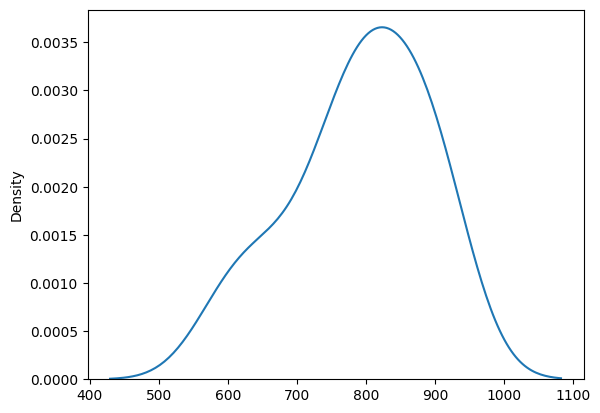

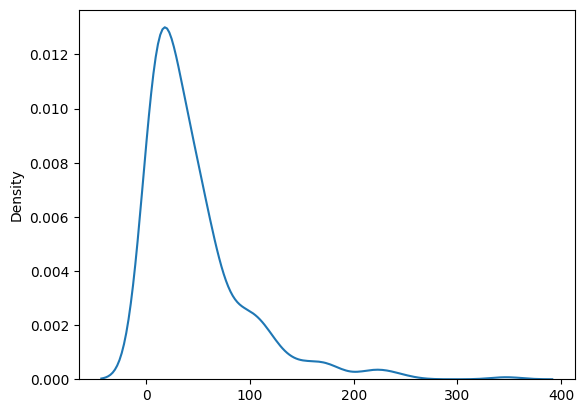

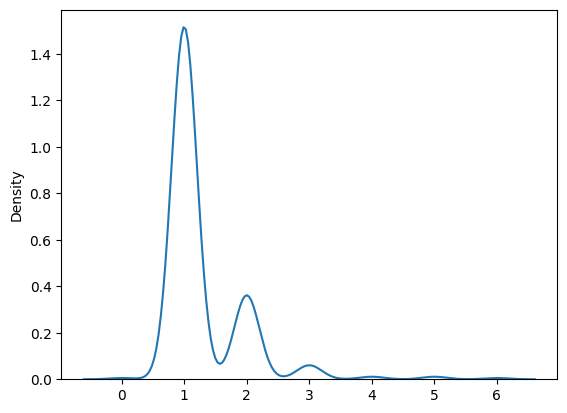

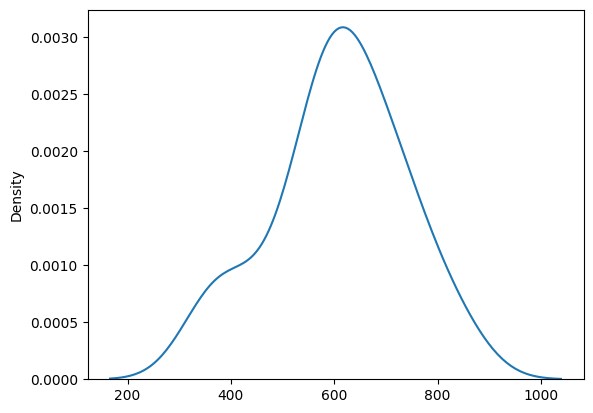

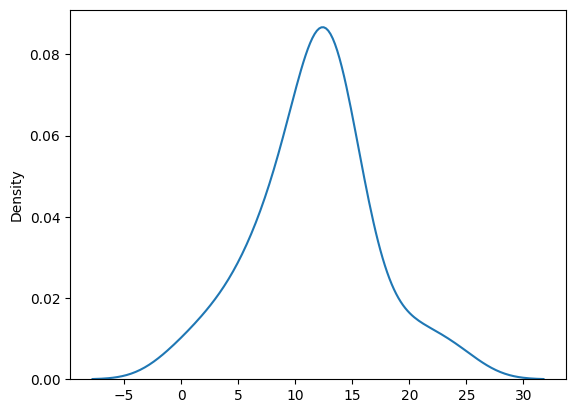

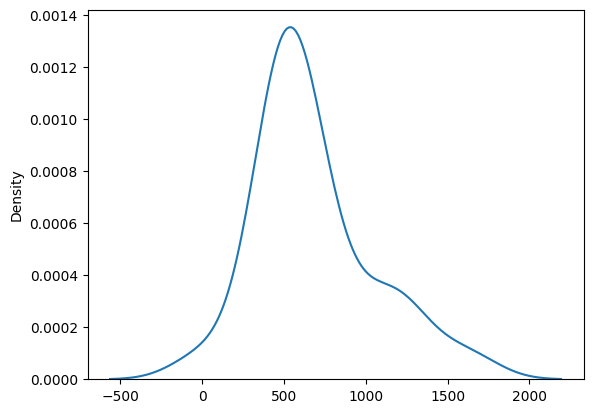

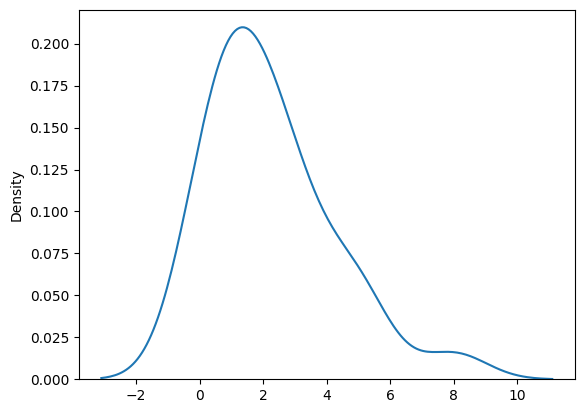

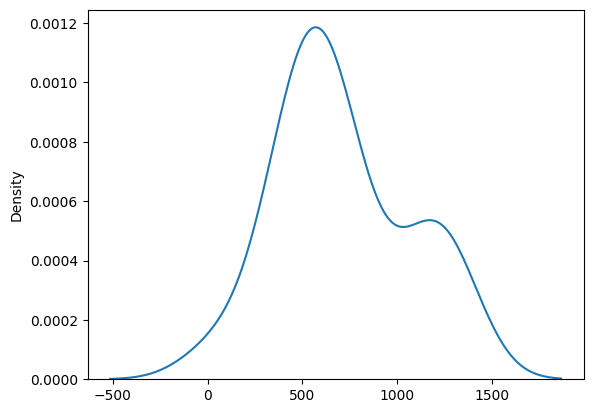

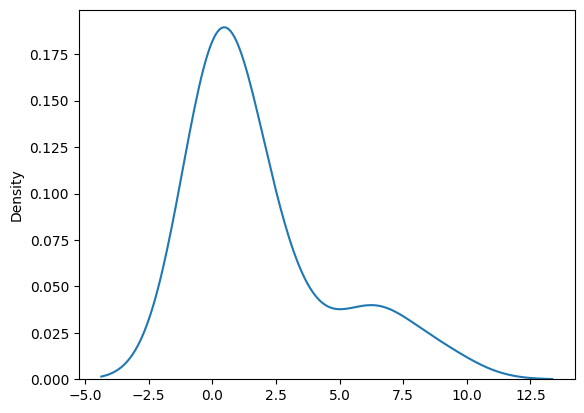

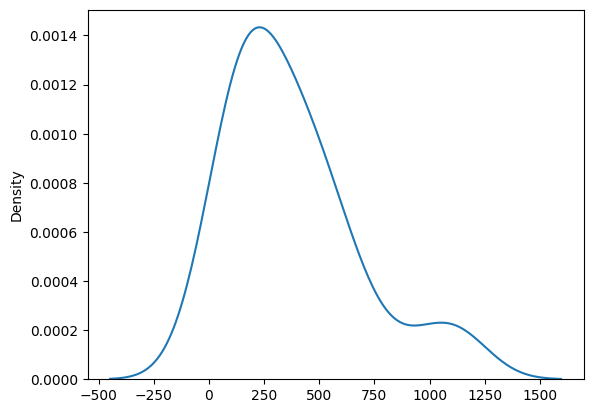

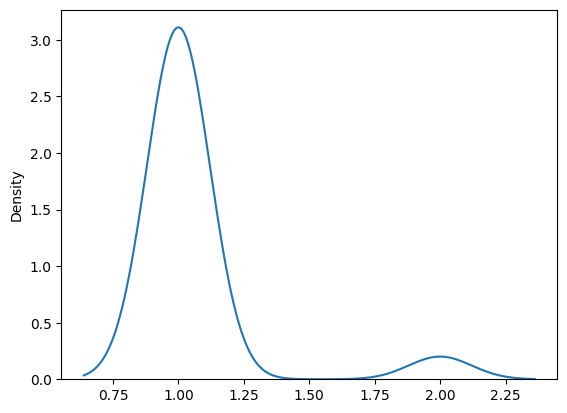

In [10]:
dates = ["1122", "1123", "1128"]
data_dict = dict([(date, 0) for date in dates])
for date in dates:
    data_dict[date] = preprocess(date)
    
draw(pd.concat(data_dict.values()))